Nama : Muhammad Faishal Azhar Suherman

NIM : 23524047

**TUGAS IF5250 - MINI TRANSFORMER FROM SCRATCH**

# Instalasi Library yang diperlukan

Dilakukan persiapan untuk library serta pembuatan fungsi untuk pembuatan transformer

In [ ]:
!pip install transformers

In [ ]:
!pip install --quiet gcsfs

In [ ]:
from google.colab import drive
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import string
import re
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizerFast
import matplotlib.pyplot as plt

# EDA

##Data set Hugging face

In [ ]:
# Load dataset dari Hugging Face
df = pd.read_parquet("hf://datasets/nutorbit/news-headline-gen/data/train-00000-of-00001-6514c1e1dfd87aa3.parquet")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Menampilkan isi dataset
df.describe()

,headline,news
count,21157,21157
unique,19417,19437
top,Japan Earthquake Death Toll: 200 to 300 Found ...,"(Mar 11, 2011 9:10 AM) The death toll continu..."
freq,4,4


In [ ]:
'''Mengubah text menjadi lowercase, lalu menghilangkan simbol
dan angka yang tidak diperlukan'''
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [ ]:
'''Mengambil sample data secara acak dan melakukan cleaning'''
df = df[['headline']].dropna()
df_sample = df.sample(n=1500, random_state=42).reset_index(drop=True)
df_sample['cleaned'] = df_sample['headline'].apply(clean_text)

In [ ]:
df_sample = df_sample[['cleaned']]
df_sample = df_sample[df_sample['cleaned'].str.len() > 20].reset_index(drop=True)

In [ ]:
# Menyimpan hasil csv yang sudah dicleaning
df_sample[['cleaned']].to_csv("cleaned_headlines.csv", index=False)

Dilakukan pembersihan data dengan mengubah kata yang ada menjadi lowercase, menghilangkan simbol, whitespace, extraspace, dan angka yang tidak diperlukan

## Load dataset hasil cleaning

In [ ]:
# Load & Split Dataset
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Deep_learning_Tubes/cleaned_headline_data.csv')
train_texts, test_texts = train_test_split(df['cleaned'].values, test_size=0.2, random_state=42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df

,cleaned
0,New energy law promises to revolutionize the e...
1,Climate change continues to be a global threat
2,Investors seek opportunities in renewable energy
3,Demand for electric vehicles increases
4,COVID-19 vaccines: When will we all be protected?
...,...
1320,The potential of renewable energy storage solu...
1321,The benefits of eco-friendly landscaping pract...
1322,The influence of digital platforms in advancin...
1323,The role of sustainable packaging innovations ...


In [ ]:
df.describe()

,cleaned
count,1325
unique,1202
top,Threats and Challenges in a Hyperconnected World
freq,6


In [ ]:
len(df)

1325

In [ ]:
len(train_texts)

1060

In [ ]:

len(test_texts)

265

Loading dataset dilakukan untuk mempermudah pengambilan data

#Tokenization

In [ ]:
#  Tokenization Layer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

sequence_length = 64
embedding_dim = 128
vocab_size = tokenizer.vocab_size

In [ ]:
# Tokenisasi untuk Language Modeling
def tokenize_lm(texts):
    encodings = tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=sequence_length,
        return_tensors='tf'
    )
    input_ids = encodings['input_ids']
    return input_ids[:, :-1], input_ids[:, 1:]

# Buat Dataset
def make_dataset(text_array):
    x, y = tokenize_lm(text_array)
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    return ds.batch(64).prefetch(tf.data.AUTOTUNE)

# Dataset untuk training dan testing
train_ds = make_dataset(train_texts)
test_ds = make_dataset(test_texts)


Digunakan tokenizer dari huggingface dengan bert tokenizer untuk vocabulary. Isi dari tokenizer ini dapat digunakan untuk memprediksi kata
selanjutnya. Alasan pemilihan tokenizer ini adalah sudah banyak dipakai, kompatibel dengan
model yang dibuat, serta sesuai dengan task yang diperlukan untuk generate headline.  

# Model awal

In [ ]:
# Hyperparameter
sequence_length = 64
embedding_dim = 128

num_heads = 4
ff_dim = 128
batch_size = 32
epochs = 10

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
vocab_size = tokenizer.vocab_size
sequence_length = 64

def tokenize_and_shift(texts):
    encodings = tokenizer(
        list(texts),
        padding="max_length",
        truncation=True,
        max_length=sequence_length,
        return_tensors="tf"
    )
    input_ids = encodings["input_ids"]
    labels = tf.concat([input_ids[:, 1:], tf.constant(tokenizer.pad_token_id, shape=(input_ids.shape[0], 1))], axis=-1)
    return input_ids, labels

# Buat Dataset
def make_dataset(text_array):
    x, y = tokenize_and_shift(text_array)
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    return ds.batch(64).prefetch(tf.data.AUTOTUNE)

# Dataset untuk training dan testing
train_ds = make_dataset(train_texts)
test_ds = make_dataset(test_texts)

In [ ]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat([tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0)
    return tf.tile(mask, mult)

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
class DecoderOnlyTransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=None):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        attn_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
def build_decoder_only_model(num_heads, ff_dim):
    inputs = layers.Input(shape=(None,), dtype=tf.int32)
    embedding_layer = TokenAndPositionEmbedding(sequence_length, vocab_size, embedding_dim)
    x = embedding_layer(inputs)
    x = DecoderOnlyTransformerBlock(embedding_dim, num_heads=num_heads, ff_dim=ff_dim)(x)
    outputs = layers.Dense(vocab_size)(x)
    return keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
def tokenize_and_shift(texts):
    encodings = tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=sequence_length,
        return_tensors="tf"
    )
    input_ids = encodings["input_ids"]
    labels = tf.concat([input_ids[:, 1:], tf.fill([input_ids.shape[0], 1], tokenizer.pad_token_id)], axis=-1)
    return input_ids, labels

In [ ]:
decoder_model = build_decoder_only_model(num_heads=4, ff_dim=128)
decoder_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(), metrics=["accuracy"])
decoder_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_3  │ (None, None, 128)      │     3,915,008 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_only_transformer_block… │ (None, None, 128)      │       297,344 │
│ (DecoderOnlyTransformerBlock)   │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, None, 30522)    │     3,937,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,149,690 (31.09 MB)

 Trainable params: 8,149,690 (31.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class TextGenerator(keras.callbacks.Callback):
    """callback dalam generate kata dari model yang dilatih

    parameter:
        max_tokens: Bentuk Integer, merupakan jumlah token yang digenerate dari prompt yang masuk.
        start_tokens: List integer, token yang mengindikasikan prompt yang masuk.
        top_k: Integer, sampel dari top prediksi token.
        print_every: Integer, menampilkan data setelah berapa kali epoch yang dilakukan.
    """
    def __init__(self, max_tokens, start_tokens, tokenizer, top_k=10, print_every=1):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.tokenizer = tokenizer
        self.print_every = print_every
        self.k = top_k

    def sample_from(self, logits):
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.print_every != 0:
            return

        start_tokens = list(self.start_tokens)
        tokens_generated = []

        while len(tokens_generated) <= self.max_tokens:
            x_input = start_tokens + [0] * (sequence_length - len(start_tokens))
            x = np.array([x_input[:sequence_length]])
            y = self.model.predict(x, verbose=0)
            next_token = self.sample_from(y[0, len(start_tokens) - 1])
            tokens_generated.append(next_token)
            start_tokens.append(next_token)

        # Gabungkan semua token dan decode jadi teks
        all_tokens = self.start_tokens + tokens_generated
        decoded_text = self.tokenizer.decode(all_tokens, skip_special_tokens=True)
        print(f"\nGenerated text (epoch {epoch+1}):\n{decoded_text}\n")



In [ ]:
# Memanggil tokenizer dan mengubah menjadi text
vocab = tokenizer.get_vocab()
index_to_word = {v: k for k, v in vocab.items()}

start_prompt = "blockchain"
start_tokens = tokenizer.encode(start_prompt, add_special_tokens=False)

text_gen_callback = TextGenerator(
    max_tokens=40,
    start_tokens=start_tokens,
    tokenizer=tokenizer
)

In [ ]:
# Melatih Model yang sudah dibuat
history_awal = decoder_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=[text_gen_callback]
)


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.6714 - loss: 9.1998
Generated text (epoch 1):
blockchain of in in : sustainable : the for sustainable and and in in in sustainable and : on and on a sustainable a : on on

17/17 ━━━━━━━━━━━━━━━━━━━━ 23s 758ms/step - accuracy: 0.6780 - loss: 9.1531 - val_accuracy: 0.8432 - val_loss: 6.2722
Epoch 2/20
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8395 - loss: 5.4710
Generated text (epoch 2):
blockchain - the of of of and and the in and a a in of and the future of in

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - accuracy: 0.8395 - loss: 5.3706 - val_accuracy: 0.8432 - val_loss: 2.5709
Epoch 3/20
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8395 - loss: 2.0295
Generated text (epoch 3):
blockchain :

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - accuracy: 0.8395 - loss: 1.9829 - val_accuracy: 0.8432 - val_loss: 1.0649
Epoch 4/20
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8405 - loss: 1.0091
Generated te

In [ ]:
#  Evaluasi: function loss
loss, acc = decoder_model.evaluate(test_ds)
print(f"\nFinal Loss: {loss:.4f} | Final Accuracy: {acc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9117 - loss: 0.5746

Final Loss: 0.5877 | Final Accuracy: 0.9090


In [ ]:
# Purplexity - Evaluasi
# Ambil loss validasi terakhir
val_loss = history_awal.history['val_loss'][-1]

# Hitung perplexity
perplexity = np.exp(val_loss)

print(f"Perplexity: {perplexity:.4f}")

Perplexity: 1.7999


In [ ]:
# Text untuk predict
class TextPredict:
    """call back untuk generate text dari model yang sudah di train.

    parameter:
        max_tokens: Bentuk Integer, merupakan jumlah token yang digenerate dari prompt yang masuk.
        start_tokens: List integer, token yang mengindikasikan prompt yang masuk.
        top_k: Integer, sampel dari top prediksi token.
        print_every: Integer, menampilkan data setelah berapa kali epoch yang dilakukan.
    """
    def __init__(self, model, max_tokens, start_tokens, tokenizer, top_k=10):
        self.model = model
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.tokenizer = tokenizer
        self.k = top_k

    def sample_from(self, logits):
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)

    def generate(self):
        start_tokens = list(self.start_tokens)
        tokens_generated = []

        while len(tokens_generated) <= self.max_tokens:
            padded_input = start_tokens + [0] * (sequence_length - len(start_tokens))
            x = np.array([padded_input[:sequence_length]])
            y = self.model.predict(x, verbose=0)
            next_token = self.sample_from(y[0, len(start_tokens) - 1])
            tokens_generated.append(next_token)
            start_tokens.append(next_token)

        all_tokens = self.start_tokens + tokens_generated
        decoded_text = self.tokenizer.decode(all_tokens, skip_special_tokens=True)
        print(f"\nGenerated text:\n{decoded_text}\n")

In [ ]:
num_tokens_generated = 20

def generateHeadling(start_prompt):
    # Tokenisasi prompt untuk menampilkan informasi dari token
    encoded = tokenizer.encode_plus(
        start_prompt,
        add_special_tokens=False,
        return_attention_mask=False,
        return_token_type_ids=False
    )
    tokens = tokenizer.convert_ids_to_tokens(encoded['input_ids'])

    print("Prompt tokens:", tokens)

    # Menggunakan token ID sebagai start_tokens
    start_tokens = encoded['input_ids']

    # Menjalankan fungsi TextPredict
    text_predict = TextPredict(
        model=decoder_model,
        max_tokens=num_tokens_generated,
        start_tokens=start_tokens,
        tokenizer=tokenizer
    )
    text_predict.generate()


In [ ]:
# Generate Text:
generateHeadling("intelligence")

Prompt tokens: ['intelligence']

Generated text:
intelligence the role of eco - friendly transportation solutions in reducing environmental impact.



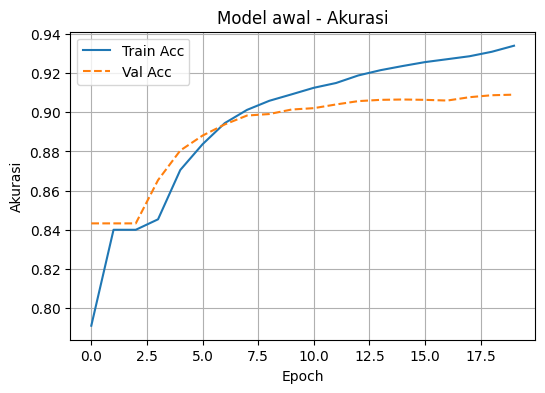

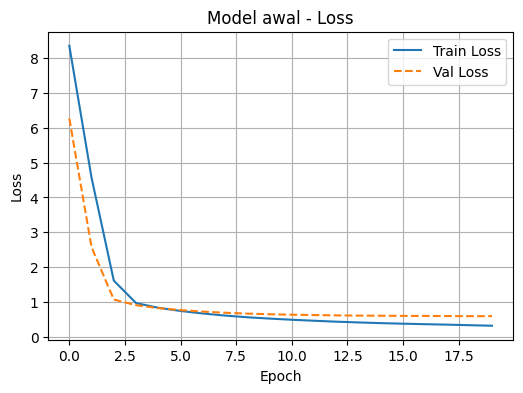

In [ ]:
# Akurasi Model awal
plt.figure(figsize=(6, 4))
plt.plot(history_awal.history['accuracy'], label='Train Acc')
plt.plot(history_awal.history['val_accuracy'], linestyle='--', label='Val Acc')
plt.title('Model awal - Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)
plt.show()

# Loss Model awal
plt.figure(figsize=(6, 4))
plt.plot(history_awal.history['loss'], label='Train Loss')
plt.plot(history_awal.history['val_loss'], linestyle='--', label='Val Loss')
plt.title('Model awal - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Membuat model

In [ ]:
#  Causal Attention Mask
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Parameter:
    - batch_size (int): Jumlah sequence dari tiap batch.
    - n_dest (int): Panjang sequence tujuan (Jumlah token dalam setiap sekuen yang diproses).
    - n_src (int): Panjang sequence sumber
    - dtype (tf.DType): jenis data untuk mask pada tensor (seperti tf.float32, tf.int32).

    Output:
    - tf.Tensor: Output bentuk tensor [batch_size, n_dest, n_src] dimana
      bagian segitiga atas dari matriks hasil perkalian dot diisi dengan nol
      sedangkan dibagian bawahnya diisi dengan satu. Bagian ini digunakan untuk melakukan mask
      attention weights dalam self attention, sehingga setiap token hanya dapat mencari hubungan antara
      token sebelumnya dengan dirinya sendiri.

    Contoh Penggunaan:
    >>> causal_mask = causal_attention_mask(2, 4, 4, tf.float32)
    >>> print(causal_mask)
    <tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
    array([[[1., 0., 0., 0.],
            [1., 1., 0., 0.],
            [1., 1., 1., 0.],
            [1., 1., 1., 1.]],

           [[1., 0., 0., 0.],
            [1., 1., 0., 0.],
            [1., 1., 1., 0.],
            [1., 1., 1., 1.]]], dtype=float32)>
    """
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat([tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0)
    return tf.tile(mask, mult)

`causal_attention_mask` ini adalah fungsi yang melakuakn masking pada setiap kata didalam kalimat yang menghubungkan relasi antara kata sebelumnya dengan dirinya sendiri tanpa melihat kata setelahnya. Hal ini penting karena untuk mencegah model untuk menggunakan data setelahnya untuk prediksi untuk generate kata. Hal ini dilakukan untuk memastikan hasil output textnya jelas dan berurutan.

In [ ]:
#  Transformer Block
class TransformerBlock(layers.Layer):
    """
    Berupa blok arsitektur dari transformer yang melakukan kombinasi antara multi-head attention
    dan feed-forward network untuk memproses input yang masuk.

    Transformer ini di desain untuk mempelajari relasi yang kompleks dari data dengan menggunakan self attention.
    pada bagian ini juga dibuat layer normalization dan dropout untuk menghindari overfitting.

    attribut:
    - embed_dim (int): Ukuran dimensi dari embedding space.
    - num_heads (int): Jumlah head attention dari mekanisme multi head attention.
    - ff_dim (int): Dimensi dari hidden layer pada jaringan feed forward.
    - rate (float): nilai dropout pada layer attention dan feed forward.

    Metode :
    - call(input): Melakukan proses pass forward dari transformer. Lalu akan diterapkan multi-head attention,
      Residual connection, normalisasi output, lalu akan diproses melalui feed-forward network.

    Parameters:
    - inputs (tf.Tensor): Input tensor dengan bentuk (batch_size, seq_len, embed_dim).
      Berupa hasil representasi dari sequence of embedding.

    Output:
    - tf.Tensor: Output tensor dalam bentuk (batch_size, seq_len, embed_dim).
      Berupa hasil sekuen yang telah melalui proses attention, feed forward,
      normalization.

    Contoh Penggunaan:
    >>> transformer_block = TransformerBlock(embed_dim=64, num_heads=4, ff_dim=128)
    >>> inputs = tf.random.uniform((32, 10, 64))  # Example input tensor with batch_size=32, seq_len=10, embed_dim=64
    >>> output = transformer_block(inputs)
    >>> print(output.shape)
    (32, 10, 64)
    """
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        # Menggunakan multihead attention untuk mencari relasi antar posisi dari sekuen.
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # Feed Forward dengan fungsi aktivasi ReLU.
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        # Melakukan normalisasi.
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
         # Dropout layer untuk mencegah overfitting.
        self.dropout1 = layers.Dropout(rate)  # Dropout setelah proses attention.
        self.dropout2 = layers.Dropout(rate)  # Dropout setelah feed forward netwrok.

    def call(self, inputs, training=None, mask=None):
        """
        Bagian call untuk melakukan forward pass dari transformer.

        artribut:
        inputs -- input tensor ke bagian blok Transformer.

        keluaran:
        The output tensor of the Transformer block after applying attention, dropout, and feed-forward network.
        """
        batch_size = tf.shape(inputs)[0] # Banyaknya sequence tiap batch.
        seq_len = tf.shape(inputs)[1] # Panjang tiap sequence.

        # Menggunakan masking untuk mencegah melihat token setelahnya.
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        if mask is not None:
            padding_mask = tf.cast(tf.expand_dims(mask, axis=1), tf.bool)
            combined_mask = tf.logical_and(padding_mask, causal_mask)
        else:
            combined_mask = causal_mask

        # Melakukan multi-head attention dengan menggunakan masking.
        attn_output = self.att(inputs, inputs, attention_mask=combined_mask)

        # Menggunakan dropout dari output attention.
        attn_output = self.dropout1(attn_output, training=training)

        # Menambah input dari residual connecton dan melakukan normalisasi.
        out1 = self.layernorm1(inputs + attn_output)

        # Melakukan feed forward.
        ffn_output = self.ffn(out1)

        # Menggunakan dropout dari feed forward network.
        ffn_output = self.dropout2(ffn_output, training=training)

        # Menambah input dari hasil normalisasi dari feed forward network.
        return self.layernorm2(out1 + ffn_output)

Class `TransformerBlock` adalah blok transformer yang dibuat dalam deep learning kita. bagian blok ini yang akan digunakan untuk menghandle sequence berupa text yang sudah dipersiapkan pada dataset.

`TransformerBlock` ini digunakan untuk mengeksekusi part dari transformer yang telah dibuat. Model ini perlu mempelajari kata dari sekunse kalimat yang terhubung satu dengan yang lain walaupun jaraknya berjauhan. Maka transformer ini akan menggunakan attention dan feed forward yang mencari relasi keterhubungan antar kata.  Komponen yang digunakan pada tranformer adalah sebagai berikut :

* **Self-Attention Mechanism:**
Bagian ini akan melihat kata yang berkaitan. Disini akan dilakukan **perhitungan tiap kata yang berhubungan dengan kata lainnya didalam kalimat** Bagian inilah yang disebut dengan self attention. **Transformer block** ini membantu model untuk mengetahui bagaimana antar kata saling terhubung satu dengan yang lainnya walaupun tidak berdekatan.

* **Feed-Forward Network:**
Setelah Mencari keterhubungan antar kata, maka step selanjutnya adalah memastikan informasi ini digunakan dalam jaringan kita. disinilah feed forward ini digunakan untuk mengetahui pattern pola dari data.

* **Normalization and Dropout:**
Untuk memastikan model ini mempelajari data dengan baik, maka ditambahkan bagian normalisasi dan dropout untuk menstabilkan model dalam proses training dan mencegah terjadinya overfitting.

In [ ]:
#  Positional Embedding Layer
class TokenAndPositionEmbedding(layers.Layer):
    """
    Attributes:
    - maxlen (int): Panjang maksimum dari dari input sekuen.
    - vocab_size (int): jumlah dari kosakata yang digunakan.
    - embed_dim (int): Dimensi dari embedding space. setiap token akan mewakili sebagai vektor berdimensi x

    Metode:
    - call(x): Mengimplementasikan tokenize dan positional encoding dari input. Bagian ini akan menghasilkan
      hasil embedding antara token dengan posisi dalam data sekuen.

    Parameters:
    - x (tf.Tensor): Input tensor (batch_size, sequence_length).

    Output:
    - tf.Tensor: Output tensor (batch_size, sequence_length, embed_dim), berupa hasil token yang diubah
      menjadi vektor dengan isi token dan posisi

    Contoh:
    >>> embedding_layer = TokenAndPositionEmbedding(maxlen=100, vocab_size=5000, embed_dim=64)
    >>> input_seq = tf.constant([[1, 5, 9], [2, 6, 3]]) -- urutan 1, dan 2 dengan dimensi 2,3 (2 kalimat sepanjang 3 token)
    >>> output = embedding_layer(input_seq)
    >>> print(output.shape)
    (2, 3, 64) => (jumlah kalimat, jumlah token, dimensi embedding)
    """
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()

        # Embedding layer untuk tokenized.
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)

        # Embedding layer untuk positional encoding.
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        """
        Mengimplementasikan token dan positional encoding.

        Parameter:
        x -- input tensor berisi token.

        output:
        tensor yang telah ditambahkan token dan posisi.
        """

        # Menghasilkan posisi dari 0 hingga maxlen-1.
        positions = tf.range(start=0, limit=tf.shape(x)[-1], delta=1)

        # Menggunakan positional embedding layer untuk mencari posisi.
        positions = self.pos_emb(positions)

        # Menggunakan token embedding layer untuk token
        x = self.token_emb(x)

        # Menambahkan token + posisi untuk mengetahui token dan posisi dari data input.
        return x + positions

`TokenAndPositionEmbedding` ini adalah class yang digunakan untuk mengubah token menjadi bentuk representasi angka yang akan digunakan dalam model.
**Class ini menggunakan 2 aspek kunci diantara:**

* **Token Representation:** Mengubah token sekuen menjadi bentuk vector yang dikenal dengan **token embedding**.

* **Positional Information:** Untuk mengetahui urutan dari token, maka perlu diketahui posisi dari token tersebut. maka diperlukan**positional embeddings**. embedding ini digunakan untuk mengetahui posisi dari tiap token dimana diharapkan model dapat memahami konteks serta posisi dari tiap token yang ada.

In [ ]:
#  Transformer Model
'''
Hyperparameter
embedding_dim : Ukuran dimensi dari tiap token
num_heads : jumlah attention head pada model (dapat meningkatkan performa model)
ff_dim : Ukuran hidden layer pada feed forward network
'''

def build_model(num_heads, ff_dim):
    inputs = layers.Input(shape=(None,), dtype=tf.int32)
    # Memuat Embedding layer dengan positional encoding
    embedding_layer = TokenAndPositionEmbedding(sequence_length, vocab_size, embedding_dim)
    x = embedding_layer(inputs)
    mask = embedding_layer.token_emb.compute_mask(inputs)
    # Memuat blok transformer dengan normalisasi dan dropout
    x = TransformerBlock(embedding_dim, num_heads=num_heads, ff_dim=ff_dim)(x, mask=mask)
    x = TransformerBlock(embedding_dim, num_heads=num_heads, ff_dim=ff_dim)(x, mask=mask)
    # Output layer
    x = layers.Dense(vocab_size)(x)
    # Melakukan compile model dari input output
    return keras.Model(inputs=inputs, outputs=x)

In [ ]:
# Melakukan pembuatan model
model = build_model(num_heads=2, ff_dim=64)
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(), metrics=["accuracy"])

In [ ]:
class TextGenerator(keras.callbacks.Callback):
    """callback dalam generate kata dari model yang dilatih

    parameter:
        max_tokens: Bentuk Integer, merupakan jumlah token yang digenerate dari prompt yang masuk.
        start_tokens: List integer, token yang mengindikasikan prompt yang masuk.
        top_k: Integer, sampel dari top prediksi token.
        print_every: Integer, menampilkan data setelah berapa kali epoch yang dilakukan.
    """
    def __init__(self, max_tokens, start_tokens, tokenizer, top_k=10, print_every=1):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.tokenizer = tokenizer
        self.print_every = print_every
        self.k = top_k

    def sample_from(self, logits):
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.print_every != 0:
            return

        start_tokens = list(self.start_tokens)
        tokens_generated = []

        while len(tokens_generated) <= self.max_tokens:
            x_input = start_tokens + [0] * (sequence_length - len(start_tokens))
            x = np.array([x_input[:sequence_length]])
            y = self.model.predict(x, verbose=0)
            next_token = self.sample_from(y[0, len(start_tokens) - 1])
            tokens_generated.append(next_token)
            start_tokens.append(next_token)

        # Gabungkan semua token dan decode jadi teks
        all_tokens = self.start_tokens + tokens_generated
        decoded_text = self.tokenizer.decode(all_tokens, skip_special_tokens=True)
        print(f"\nGenerated text (epoch {epoch+1}):\n{decoded_text}\n")


`TextGenerator` ini merupakan callback yang dibuat untuk melakukan generate headline dari model yang telah dilatih selama proses training. step yang dilakukan adalah sebagai berikut :

1. **Initialization:** set parameter yang diperlukan:

- **max_tokens:** banyak token untuk melakukan generate headline dari promt.
- **start_tokens:** Token awal sebagai titik awal dari proses generate headline.
- **top_k:** Limit sampling dari preidiksi top k token.
- **print_every:** Banyaknya epoch yang diperlukan untuk melakukan generate headline.
- **Text Sampling:** memilih token berikutnya dari probabilitas prediksi dari model. yang berfokus pada top k token yang sering muncul.

2. **Token Conversion:** detokenize untuk mengubah deretan indeks token ini menjadi kata dengan bantuan mapping yang telah disusun.

3. **Text Generation:** menghasilkan teks baru dari token awal, lalu melakukan prediksi tiap token hingga mencapai panjang text yang diinginkan. lalu hasil teks akan ditampilkan setelah epoch yang dilakukan selama proses training.

bagian ini membantu pengamat dalam mengamai dan mengevaluasi model selama proses pelatihan, dimana selain melihat loss dari proses training, kita juga dapat melihat hasil generated text secara langsung selama proses pelatihan.

In [ ]:
# Memanggil tokenizer dan mengubah menjadi text
vocab = tokenizer.get_vocab()
index_to_word = {v: k for k, v in vocab.items()}

start_prompt = "blockchain"
start_tokens = tokenizer.encode(start_prompt, add_special_tokens=False)

text_gen_callback = TextGenerator(
    max_tokens=40,
    start_tokens=start_tokens,
    tokenizer=tokenizer
)


#Model 1

##Melatih model 1

parameter

*   num_heads=2
*   ff_dim=64



In [ ]:
# Melatih Model yang sudah dibuat
history1 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=[text_gen_callback]
)


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.6672 - loss: 9.2361
Generated text (epoch 1):
blockchain : for in : of in and : and a of - in the a in the in : in for in. : the : for in for of

17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 809ms/step - accuracy: 0.6739 - loss: 9.1904 - val_accuracy: 0.8407 - val_loss: 6.3904
Epoch 2/20
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8369 - loss: 5.6279
Generated text (epoch 2):
blockchain the. - in the the in and of in the in and of :

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 235ms/step - accuracy: 0.8370 - loss: 5.5310 - val_accuracy: 0.8407 - val_loss: 2.7754
Epoch 3/20
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8370 - loss: 2.2139
Generated text (epoch 3):
blockchain in :

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - accuracy: 0.8370 - loss: 2.1613 - val_accuracy: 0.8407 - val_loss: 1.0929
Epoch 4/20
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8381 - loss: 1.0377
Generated text (epoch 4):
blockchain and :

17/17 ━━━

Pada bagian ini dilakukan pembuatan model hasil konfigurasi model berupa arsitektur transformer yang telah dibuat. Model akan dilatih dengan menggunakan dataset dari text_ds yang telah diproses sebagai input pada model.

- Pelatihan dilakukan sebanyak **20 epoch**
- callback yang digunakan menggunakan custom call back yang telah kita buat. bagian ini akan menghasilkan **headline** secara langsung tiap 1 epoch yang telah dilakukan,

bagian ini dilakukan dengan tujuan agar pengguna dapat melihat hasil generate headline dan memberikan feed back secara langsung dari hasil pembelajaran dari model yang telah dibuat.

## Evaluasi Model 1

### Evaluasi : loss

In [ ]:
#  Evaluasi: function loss
loss, acc = model.evaluate(test_ds)
print(f"\nFinal Loss: {loss:.4f} | Final Accuracy: {acc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9118 - loss: 0.5783

Final Loss: 0.5907 | Final Accuracy: 0.9102


Melakukn evaluasi dari loss pada proses training dengan data test. didapatkan model menghasilkan performa yang cukup baik dari segi training dan test dengan data test

### Evaluasi : Purplexity

In [ ]:
# Purplexity - Evaluasi
# Ambil loss validasi terakhir
val_loss = history1.history['val_loss'][-1]

# Hitung perplexity
perplexity = np.exp(val_loss)

print(f"Perplexity: {perplexity:.4f}")

Perplexity: 1.8053


Perplexity yang rendah ini menunjukkan bahwa model cukup confidence dalam memprediksi kata selanjutnya sehingga bisa dilihat bahwa model dapat merangkai kata demi kata dengan baik.

### Text predict untuk generate kata

In [ ]:
class TextPredict:
    """call back untuk generate text dari model yang sudah di train.

    parameter:
        max_tokens: Bentuk Integer, merupakan jumlah token yang digenerate dari prompt yang masuk.
        start_tokens: List integer, token yang mengindikasikan prompt yang masuk.
        top_k: Integer, sampel dari top prediksi token.
        print_every: Integer, menampilkan data setelah berapa kali epoch yang dilakukan.
    """
    def __init__(self, model, max_tokens, start_tokens, tokenizer, top_k=10):
        self.model = model
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.tokenizer = tokenizer
        self.k = top_k

    def sample_from(self, logits):
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)

    def generate(self):
        start_tokens = list(self.start_tokens)
        tokens_generated = []

        while len(tokens_generated) <= self.max_tokens:
            padded_input = start_tokens + [0] * (sequence_length - len(start_tokens))
            x = np.array([padded_input[:sequence_length]])
            y = self.model.predict(x, verbose=0)
            next_token = self.sample_from(y[0, len(start_tokens) - 1])
            tokens_generated.append(next_token)
            start_tokens.append(next_token)

        all_tokens = self.start_tokens + tokens_generated
        decoded_text = self.tokenizer.decode(all_tokens, skip_special_tokens=True)
        print(f"\nGenerated text:\n{decoded_text}\n")

`TextPredict` ini merupakan callback yang dibuat untuk melakukan generate headline dari model yang telah dilatih selama proses training. step yang dilakukan adalah sebagai berikut :

1. **Initialization:** set parameter yang diperlukan:

- **max_tokens:** banyak token untuk melakukan generate headline dari promt.
- **start_tokens:** Token awal sebagai titik awal dari proses generate headline.
- **top_k:** Limit sampling dari preidiksi top k token.
- **print_every:** Banyaknya epoch yang diperlukan untuk melakukan generate headline.

2. **Detokenizing:** detokenize untuk mengubah deretan indeks token ini menjadi kata dengan bantuan mapping yang telah disusun.

3. **Text Generation:** menghasilkan teks baru dari token awal, lalu melakukan prediksi tiap token hingga mencapai panjang text yang diinginkan. lalu hasil teks akan ditampilkan setelah epoch yang dilakukan selama proses training.

bagian ini membantu pengamat dalam mengamai dan mengevaluasi model setelah proses pelatihan, dimana selain melihat loss dari proses training, kita juga dapat melihat hasil generated text secara langsung.

In [ ]:
num_tokens_generated = 20

def generateHeadling(start_prompt):
    # Tokenisasi prompt untuk menampilkan informasi dari token
    encoded = tokenizer.encode_plus(
        start_prompt,
        add_special_tokens=False,
        return_attention_mask=False,
        return_token_type_ids=False
    )
    tokens = tokenizer.convert_ids_to_tokens(encoded['input_ids'])

    print("Prompt tokens:", tokens)

    # Menggunakan token ID sebagai start_tokens
    start_tokens = encoded['input_ids']

    # Menjalankan fungsi TextPredict
    text_predict = TextPredict(
        model=model,
        max_tokens=num_tokens_generated,
        start_tokens=start_tokens,
        tokenizer=tokenizer
    )
    text_predict.generate()


Pada bagian ini, dilakukan generate headline dari model yang telah dilatih. Berikut adalah cara kerjanya :

- Hal yang pertama dilakukan adalah melakukan mapping dari kara ke indeks kata. yang memungkinkan dilakukan perubahan teks promt menjadi bentuk numerik agar dapat diproses pada model

- Lalu ditetapkan jumlah token yang dihasilkan setelah prompt awal. dilakukan proses penerimaan prompt menjadi input lalu mengubahnya menjadi token angka dengan menggunakan map kata ke indeks yang telah didefinisikan sebelumnya.

- Selanjutnya dilakukan predict yang menghasilkan urutan token baru dari prompt input yang masuk. sehingga mengeluarkan output headline.

In [ ]:
# Generate Text:
generateHeadling("intelligence")

Prompt tokens: ['intelligence']

Generated text:
intelligence sustainable fashion : a trend that promote a more sustainable cities



In [ ]:
# Generate Text:
generateHeadling("industry")

Prompt tokens: ['industry']

Generated text:
industry systems for self - care and sustainable business leadership



In [ ]:
# Generate Text:
generateHeadling("government")

Prompt tokens: ['government']

Generated text:
government the impact of electric public and reducing plastic pollution.



Dari hasil generate ini, bisa dilihat jika hasil generate dapat dibaca dan kalimat ini memiliki representasi yang cukup baik

#Model 2

beda hyperparameter heads=3, ff_dim=96

sama halnya dengan model 1 baik dari segi training maupun evaluasi model, namun yang membedakan adalah konfigurasi hyperparameternya saja.

## Melatih model 2

In [ ]:
model2 = build_model(num_heads=3, ff_dim=96)
model2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history2 = model2.fit(train_ds, validation_data=test_ds, epochs=20)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 637ms/step - accuracy: 0.6740 - loss: 9.1302 - val_accuracy: 0.8407 - val_loss: 6.2495
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.8370 - loss: 5.3870 - val_accuracy: 0.8407 - val_loss: 2.6163
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8370 - loss: 2.0603 - val_accuracy: 0.8407 - val_loss: 1.0981
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8374 - loss: 1.0439 - val_accuracy: 0.8594 - val_loss: 0.9355
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8585 - loss: 0.8934 - val_accuracy: 0.8738 - val_loss: 0.8527
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8723 - loss: 0.7981 - val_accuracy: 0.8810 - val_loss: 0.7939
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8829 - loss: 0.7222 - val_accuracy: 0.8879 - val_loss: 0.7474
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8925 - loss: 0.6574 - val_accuracy: 0.8940 -

##Evaluasi Model 2

###Evaluasi : loss

In [ ]:
#  Evaluation: Accuracy, Loss
loss, acc = model2.evaluate(test_ds)
print(f"\nFinal Loss: {loss:.4f} | Final Accuracy: {acc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9110 - loss: 0.5794

Final Loss: 0.5922 | Final Accuracy: 0.9085


### Evaluasi : Purplexity

In [ ]:
# Purplexity - Evaluasi
# Ambil loss validasi terakhir
val_loss = history1.history['val_loss'][-1]

# Hitung perplexity
perplexity = np.exp(val_loss)

print(f"Perplexity: {perplexity:.4f}")

Perplexity: 1.8080


Model 2 ini memiliki performa lebih rendah dibandingkan dengan model 1. Namun dari keseluruhan, model ini dapat bekerja dengan baik

#Model 3

beda hyperparameter heads=4, ff_dim=128

sama halnya dengan model 1 dan 2 baik dari segi training maupun evaluasi model, namun yang membedakan adalah konfigurasi hyperparameternya saja.

## Melatih model 3

In [ ]:
model3 = build_model(num_heads=4, ff_dim=128)
model3.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history3 = model3.fit(train_ds, validation_data=test_ds, epochs=20)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 568ms/step - accuracy: 0.6728 - loss: 9.1873 - val_accuracy: 0.8407 - val_loss: 6.3556
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8370 - loss: 5.5042 - val_accuracy: 0.8407 - val_loss: 2.7645
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8370 - loss: 2.1706 - val_accuracy: 0.8407 - val_loss: 1.1084
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8372 - loss: 1.0505 - val_accuracy: 0.8561 - val_loss: 0.9398
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8576 - loss: 0.8990 - val_accuracy: 0.8732 - val_loss: 0.8586
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8718 - loss: 0.8057 - val_accuracy: 0.8804 - val_loss: 0.7988
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8816 - loss: 0.7294 - val_accuracy: 0.8865 - val_loss: 0.7521
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8920 - loss: 0.6639 - val_accuracy: 0.8925 -

## Evaluasi Model 3

### Evaluasi : loss

In [ ]:
#  Evaluation: Accuracy, Loss
loss, acc = model3.evaluate(test_ds)
print(f"\nFinal Loss: {loss:.4f} | Final Accuracy: {acc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9121 - loss: 0.5755

Final Loss: 0.5891 | Final Accuracy: 0.9105


### Evaluasi : Purplexity

In [ ]:
# Purplexity - Evaluasi
# Ambil loss validasi terakhir
val_loss = history1.history['val_loss'][-1]

# Hitung perplexity
perplexity = np.exp(val_loss)

print(f"Perplexity: {perplexity:.4f}")

Perplexity: 1.8024


### Text predict untuk generate kata

Hasil predict model 3

In [ ]:
num_tokens_generated = 20

def generateHeadlingbest(start_prompt):
    # Tokenisasi prompt untuk tampilkan info token
    encoded = tokenizer.encode_plus(
        start_prompt,
        add_special_tokens=False,
        return_attention_mask=False,
        return_token_type_ids=False
    )
    tokens = tokenizer.convert_ids_to_tokens(encoded['input_ids'])

    print("Prompt tokens:", tokens)

    # Gunakan token ID sebagai start_tokens
    start_tokens = encoded['input_ids']

    # Inisialisasi dan jalankan TextPredict
    text_predict = TextPredict(
        model=model3,
        max_tokens=num_tokens_generated,
        start_tokens=start_tokens,
        tokenizer=tokenizer
    )
    text_predict.generate()


In [ ]:
# penggunaan:
generateHeadling("intelligence")

Prompt tokens: ['intelligence']

Generated text:
intelligence the impact of sustainable tourism : what on education



Model 3 ini memiliki performa lebih baik dibandingkan dengan model lainnya

# Hasil Plot

## Model 1

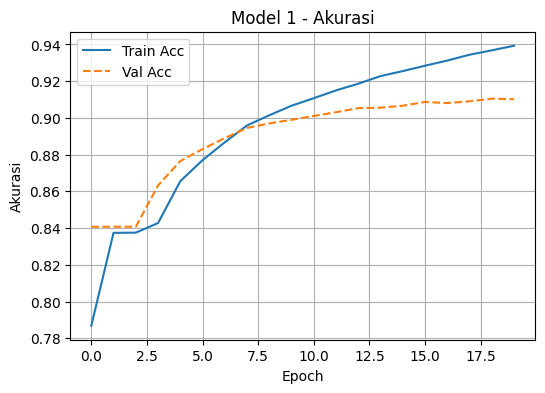

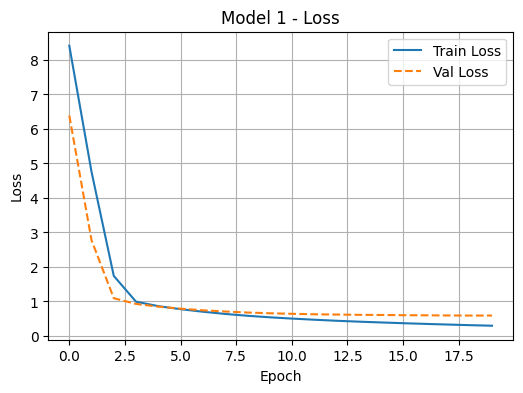

In [ ]:
# Akurasi Model 1
plt.figure(figsize=(6, 4))
plt.plot(history1.history['accuracy'], label='Train Acc')
plt.plot(history1.history['val_accuracy'], linestyle='--', label='Val Acc')
plt.title('Model 1 - Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)
plt.show()

# Loss Model 1
plt.figure(figsize=(6, 4))
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], linestyle='--', label='Val Loss')
plt.title('Model 1 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Berdasarkan kinerja dari model 1, didapatkan bahwa pada grafik los :

*   terjadi penurunan cepat pada 3 sampai 4 epoch awal. hal ini menunjukkan bahwa model dapat dengan cepat memahami pola dari data yang ada.
*   Setelah epoch ke 5, model menjadi lebih stabil, loss pun terus menurun.
*   Terdapat gap dari train loss dengan val loss di epoch epoch akhir, kemungkinan mulai terjadi overfitting.
* Namun melihat dari generate text yang telah dilakukan, dapat diketahui bahwa model ini dapat menjalankan task dengan baik.



## Model 2

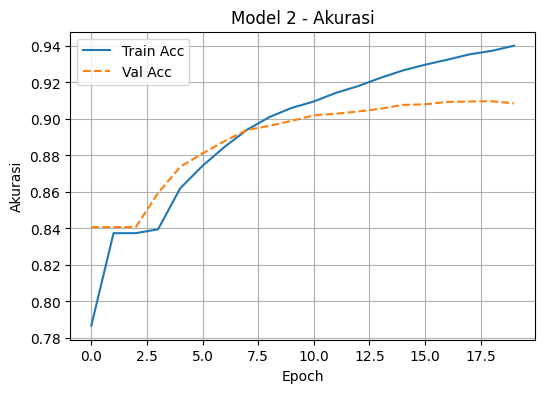

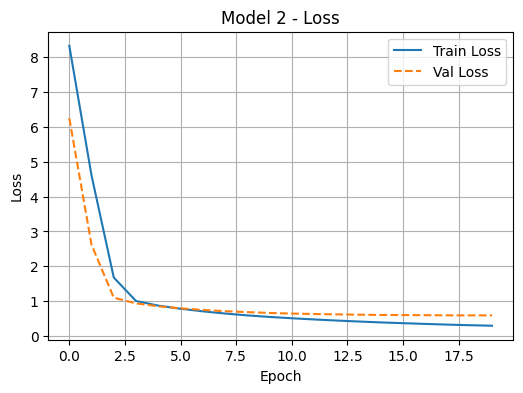

In [ ]:
# Akurasi Model 2
plt.figure(figsize=(6, 4))
plt.plot(history2.history['accuracy'], label='Train Acc')
plt.plot(history2.history['val_accuracy'], linestyle='--', label='Val Acc')
plt.title('Model 2 - Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)
plt.show()

# Loss Model 2
plt.figure(figsize=(6, 4))
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], linestyle='--', label='Val Loss')
plt.title('Model 2 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Berdasarkan kinerja dari model 2, didapatkan bahwa pada grafik los :

*   terjadi penurunan cepat pada 3 sampai 4 epoch awal. hal ini menunjukkan bahwa model dapat dengan cepat memahami pola dari data yang ada.
*   Setelah epoch ke 5, model menjadi lebih stabil, tapi terlihat validation loss terlihat lebih stagnan dibandingkan model 1
*   Terdapat gap dari train loss dengan val loss di epoch epoch akhir, kemungkinan mulai terjadi overfitting walaupun dengan nilai selisih yang cukup kecil.

## Model 3

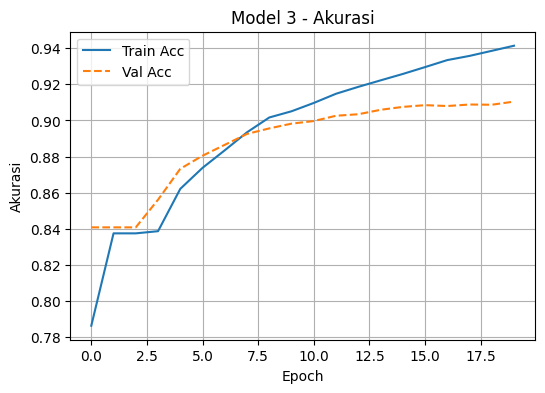

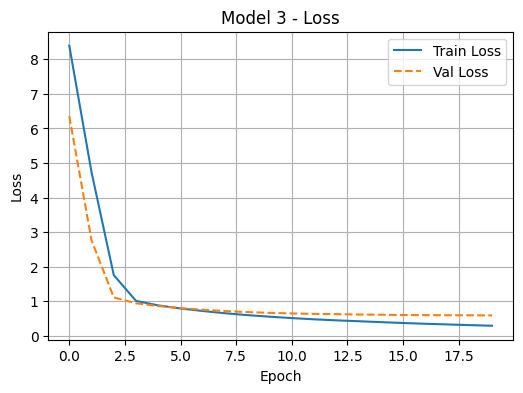

In [ ]:
# Akurasi Model 3
plt.figure(figsize=(6, 4))
plt.plot(history3.history['accuracy'], label='Train Acc')
plt.plot(history3.history['val_accuracy'], linestyle='--', label='Val Acc')
plt.title('Model 3 - Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)
plt.show()

# Loss Model 3
plt.figure(figsize=(6, 4))
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], linestyle='--', label='Val Loss')
plt.title('Model 3 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Berdasarkan kinerja dari model 3, didapatkan bahwa pada grafik los :

*   terjadi penurunan cepat pada 3 sampai 4 epoch awal. hal ini menunjukkan bahwa model dapat dengan cepat memahami pola dari data yang ada.
*   Setelah epoch ke 5, model menjadi lebih stabil dan lebih rendah dibandingkan dengan model 1 dan 2
*   Terdapat gap dari train loss dengan val loss di epoch epoch akhir, kemungkinan mulai terjadi overfitting walaupun dengan nilai selisih yang cukup kecil.
* Namun melihat dari generate text yang telah dilakukan, dapat diketahui bahwa model ini dapat menjalankan task dengan baik.

#Vanila transformer

sama halnya dengan model 1,2 dan 3 baik dari segi training maupun evaluasi model, namun yang membedakan adalah pembuatan model transformernya dimana dilakukan perubahan posisi dimana layer normalisasi diterapkan bagian awal terlebih dahulu sebelum attention

## Membuat block transformer

In [ ]:
class TransformerBlockPreNorm(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, mask=None, training=False):
        if mask is not None:
            mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype=tf.bool)

        x1 = self.layernorm1(inputs)
        attn_output = self.att(x1, x1, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = inputs + attn_output

        x2 = self.layernorm2(out1)
        ffn_output = self.ffn(x2)
        ffn_output = self.dropout2(ffn_output, training=training)
        return out1 + ffn_output


In [ ]:
def build_model_prenorm(num_heads, ff_dim):
    inputs = layers.Input(shape=(None,), dtype=tf.int32)
    embedding_layer = TokenAndPositionEmbedding(sequence_length, vocab_size, embedding_dim)
    x = embedding_layer(inputs)
    mask = embedding_layer.token_emb.compute_mask(inputs)

    # Gunakan PreNorm Transformer Block
    x = TransformerBlockPreNorm(embed_dim=embedding_dim, num_heads=num_heads, ff_dim=ff_dim)(x, mask=mask)
    x = TransformerBlockPreNorm(embed_dim=embedding_dim, num_heads=num_heads, ff_dim=ff_dim)(x, mask=mask)

    outputs = layers.Dense(vocab_size)(x)
    return keras.Model(inputs=inputs, outputs=outputs)


##Melatih Model

In [ ]:
model_prenorm = build_model_prenorm(num_heads=4, ff_dim=128)
model_prenorm.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
history_prenorm = model_prenorm.fit(train_ds, validation_data=test_ds, epochs=20)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 626ms/step - accuracy: 0.6694 - loss: 7.0786 - val_accuracy: 0.8407 - val_loss: 1.7595
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.8370 - loss: 1.3537 - val_accuracy: 0.8407 - val_loss: 1.0876
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8380 - loss: 1.0082 - val_accuracy: 0.8564 - val_loss: 0.9456
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8526 - loss: 0.9210 - val_accuracy: 0.8527 - val_loss: 0.9396
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8495 - loss: 0.9049 - val_accuracy: 0.8563 - val_loss: 0.9114
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8565 - loss: 0.8665 - val_accuracy: 0.8643 - val_loss: 0.8921
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8612 - loss: 0.8282 - val_accuracy: 0.8658 - val_loss: 0.8722
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8657 - loss: 0.7961 - val_accuracy: 0.8718 -

## Evaluasi Model

###Evaluasi : Loss

In [ ]:
#  Evaluation: Accuracy, Loss
loss, acc = model_prenorm.evaluate(test_ds)
print(f"\nFinal Loss: {loss:.4f} | Final Accuracy: {acc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9555 - loss: 0.4134

Final Loss: 0.4336 | Final Accuracy: 0.9548


### Evaluasi Purplexity

In [ ]:
# Purplexity - Evaluasi
# Ambil loss validasi terakhir
val_loss = history1.history['val_loss'][-1]

# Hitung perplexity
perplexity = np.exp(val_loss)

print(f"Perplexity: {perplexity:.4f}")

Perplexity: 1.5428


### Plot

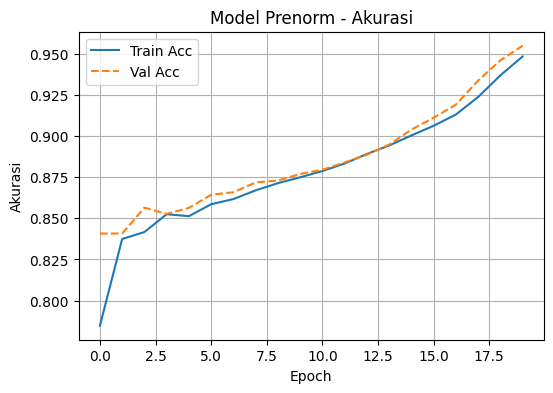

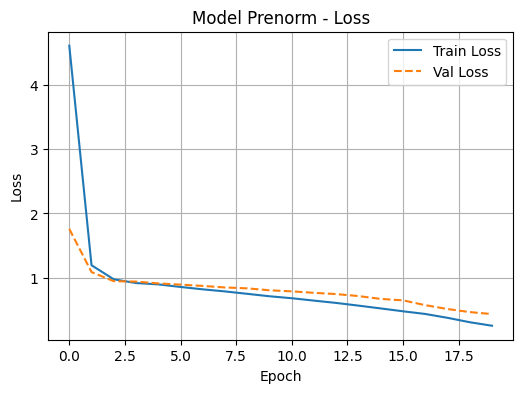

In [ ]:
# Akurasi Model Prenorm
plt.figure(figsize=(6, 4))
plt.plot(history_prenorm.history['accuracy'], label='Train Acc')
plt.plot(history_prenorm.history['val_accuracy'], linestyle='--', label='Val Acc')
plt.title('Model Prenorm - Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)
plt.show()

# Loss Model Prenorm
plt.figure(figsize=(6, 4))
plt.plot(history_prenorm.history['loss'], label='Train Loss')
plt.plot(history_prenorm.history['val_loss'], linestyle='--', label='Val Loss')
plt.title('Model Prenorm - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Berdasarkan kinerja dari model 3, didapatkan bahwa pada grafik :

*   Penurunan loss yang drastis pada epoch ke 2
*   Setelah epoch ke 3, model menjadi lebih stabil dan lebih rendah dibandingkan dengan model sebelumnya
*   Model cenderung baik dari akurasi pun model tidak terjadi indikasi overfitting dan tidak terdapat perbedaan yang signifikan sehingga model ini lebih baik dibandingkan dengan model lainnya